# Projekt numer 2 Szymon Kwieciński
Przedmiot: Zarządzanie i harmonogramowanie procesów (2024L)
Karta przedmiotu: 639B-INSWS-MEP-ZHPUZ  
Prowadzący:
    ...
Wykonał: Szymon Kwieciński nr. albumu ...  
Data: 11.04.2024  

Mail dla którego zostały podane dane dla zadania: ...  

# Table of Content  
1. [Szeregowanie zadań na jednakowych procesorach równoległych](#z_1)  
    1.1.a [Zadania podzielne](#z_1_1_a)     
    1.2.a [Zadania niepodzielne](#z_1_2_a)   
    1.2.b [Zadania niepodzielne](#z_1_2_b)   
    1.2.c [Zadania niepodzielne](#z_1_2_c)   
2. [Szeregowanie zadań na niejednorodnych proceso- rach równoległych](#z_2)  
    2.1.a [Zadania podzielne](#z_2_1_a)     
    2.1.b [Zadania podzielne](#z_2_1_b)     
    2.2.a [Zadania niepodzielne](#z_2_2_a)   
    2.2.b [Zadania niepodzielne](#z_2_2_b)    
    2.2.c [Zadania niepodzielne](#z_2_2_c)   
3. [Planowanie produkcji realizowanej w porcjach](#z_3)    
    [3.a - link](#z_3_a)  
    [3.b - link](#z_3_b)  
4. [Bibliografia](#bibl)  


In [1]:
from typing import Dict
import numpy as np
import pandas as pd
from amplpy import ampl_notebook
import amplpy
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from collections import namedtuple
import os
import math

from pandas import DataFrame

load_dotenv()

ampl: amplpy.ampl.AMPL = ampl_notebook(
    modules=["open", "minos", "cplex", "highs"],  # modules to install
    license_uuid=os.environ[
        "SIMONE_KEY_AMPL"
    ],  # license to use
)  # instantiate AMPL object and register magics
ampl.reset()

Licensed to AMPL Community Edition License for <01167477@pw.edu.pl>.


# Zadanie 1 <a name="z_1">
Szeregowanie zadań na jednakowych procesorach równoległych

## Zadanie 1.1 (a) <a name="z_1_1_a">
Na podstawie podanych danych: n — liczba procesorów, $p_j$ — czas wykonania $j$-tego zadania, określić minimalny czas, w jakim można zakończyć wszystkie zadania (Cmax). Przedstawić harmonogram reali- żujący wyznaczony czas.

### Model matematyczny
#### Faza numer 1
##### Zbiory
$i = 1,...,n$ - zbór zadań
$l = 1,...,m$ - zbiór procesorów

##### Parametry
$p_i$ - czas potrzebny do wykonania zadania $i$

##### Zmienne decyzyjne
$t_{il}$ - porcja operacji $i$ realizowana na procesorze $l$
$T$ - całkowity czas trwania harmonogramu

##### Ograniczenia  

Suma czasów dla każdego procesora jest mniejsza od całkowitego czasu trwania
$$\sum\limits_{i}t_{il} \leq T, \forall_l \quad (1.1)$$   

Suma czasów dla zadania jest mniejsza od całkowitego czasu trwania
$$\sum\limits_{l}t_{il} \leq T, \forall_i \quad (1.2)$$  

Ograniczenie wymuszające zrealizowanie każdej operacji  
$$\sum\limits_{l}t_{il}/p_i=1, \forall_i \quad (1.3)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$p_i \geq 0, \forall_i \quad (1.4)$$
$$t_{il} \geq 0, \forall{i,l} \quad (1.5)$$

##### Funkcja celu
Maksymalny czas zakończenia $C_{max}$
$$C{max} = min(T)$$


#### Faza numer 2

##### Zbiory
$i = 1,...,n$ - zbór zadań  
$l = 1,...,m$ - zbiór procesorów  
$t = 1,...,T$ - zbiór etapów  

##### Parametry
$t_{il}$ - porcja operacji $i$ realizowana na procesorze $l$;

$K$ -  współczynnik skali, pozwalający operować na całkowitoliczboych kwantach czasu harmonogramu.
$T$ - całkowity czas trwania harmonogramu w skali długości trwania pojedynczego etapu, tj. $T= C_{max}\cdot K$.

##### Zmienne decyzyjne
$v_{ilt}$ - porcja operacji $i$ realizowana na procesorze $j$ w chwili $t$. Zmienna binarna. Możliwa do użycia po wprowadzeniu $K$  

##### Ograniczenia
Ograniczenie na liczbę zadań obsługiwanych na procesorze w jednym etapie:
$$\sum_{i}v_{ilt} \leq 1,\quad ∀_{l,t}. \quad (1.6)$$

Ograniczenie na liczbę procesorów pracujących nad zadaniem w jednym etapie:
$$\sum_{l}v_{ilt} \leq 1,\quad ∀_{i,t}. \quad (1.7)$$

Ograniczenie wymuszające zrealizowanie wszystkich porcji zadań na przypisanych im procesorach:
$$\sum_{t}v_{ilt}=t_{il}\cdot K  ,\quad ∀_{i,l}. \quad (1.8)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$t_{il} \geq 0, \forall_{i,l} \quad (1.9)$$
$$K \geq 0, \quad (1.10)$$
$$T \geq 0, \quad (1.11)$$
$$v_{ilt} \geq 0,\quad \forall_{i,l,t} \quad (1.12)$$ 

##### Funkcja celu
W zadaniu 2 Fazy w zasadzie brak funkcji celu, interesuje nas jedynie znalezienie rozwiązania harmonogramu, którego długość jest już znana. Czyli w problemie tym istotne są tylko ograniczenia.

### Dane

In [2]:
# Dane
liczba_procesorow = 2

czas_wykonania_zadan = {
    "A": 16,
    "B": 12,
    "C": 5,
    "D": 12,
    "E": 13,
    "F": 10,
    "G": 8,
    "H": 7
}

### AMPL implementacja Faza 1 

In [3]:
ampl.reset()

In [4]:
%%ampl_eval
# Sets
set Procesory;
set Zadania;

#======================================================================
# Params
param Czas_wyk{ Zadania } >= 0;

#======================================================================
# Vars
var t{ Zadania, Procesory} >= 0;
var T >= 0;

#======================================================================
# Constrains

subject to ogr_1_zad_na_procesor {l in Procesory}:
    sum{i in Zadania} t[i,l] <= T;

subject to ogr_2_procesor_na_zadanie {i in Zadania}:
    sum{l in Procesory} t[i,l] <= T;


subject to ogr_3_wyk_zadania {i in Zadania}:
    sum{l in Procesory} (t[i,l]/Czas_wyk[i]) = 1;

#======================================================================
# Objective
minimize Cmax: T;


In [5]:
# Dodawanie danych do modelu matematycznego
ampl.set["Zadania"] = czas_wykonania_zadan.keys()
ampl.set["Procesory"] = [x + 1 for x in range(liczba_procesorow)]
ampl.param["Czas_wyk"] = czas_wykonania_zadan

In [6]:
# Rozwiązanie problemu
ampl.option["solver"] = "highs" # 'cplex' demo version is limited to 500 variables what is not enough 
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution; objective 41.5
2 simplex iterations
0 barrier iterations


#### Wyświetlenie rozwiązania zadania 1 fazy

In [7]:
ampl.option["display_1col"] = 0
ampl.display("t")

t [*,*]
:    1      2      :=
A   16      0
B   12      0
C    5      0
D    8.5    3.5
E    0     13
F    0     10
G    0      8
H    0      7
;



Otrzymaliśmy ułamkowe porcje realizacji zadań - aby móc wyznaczyć harmonogram potrzebujemy przeskalować wyniki mnożąc je przez 2, co będzie oznaczało, że etapy harmonogramu mają długość 1/2. Horyzont planowania wynosi Cmax*2.


In [8]:
K = 2
Cmax = ampl.obj["Cmax"].value()
T = round(K * Cmax)
print(f"Cmax={Cmax}, K={K}, T={T}")

Cmax=41.5, K=2, T=83


In [9]:
# Wyciąganie danych z modelu dla fazy 1 do zmiennych, aby użyć ich w fazie 2
Zadania = ampl.set['Zadania'].get_values().to_dict().keys()
Procesory = ampl.set['Procesory'].get_values().to_dict().keys()
Cmax: float = ampl.obj['Cmax'].value()
porcjeZadan: dict = ampl.var["t"].to_dict()

### AMPL implementacja Faza 2 

In [10]:
ampl.reset()

In [11]:
%%ampl_eval
set Procesory;
set Zadania;
#======================================================================
param Cmax;
param Kwant;
set Kwanty := 1..round(Cmax*Kwant);
param Porcje { Zadania, Procesory} >= 0;

#======================================================================
var v{Zadania, Procesory, Kwanty}>=0;
#======================================================================
subject to

	Ogr_Praca_procesora{j in Procesory, t in Kwanty}:
		sum {i in Zadania} v[i,j,t]<=1;

	Ogr_Obsluga_zadania{i in Zadania, t in Kwanty}:
		sum{j in Procesory} v[i,j,t]<=1;

	Ogr_Rozdzial_zadan{i in Zadania,j in Procesory}:
		sum{t in Kwanty} v[i,j,t]=round(Porcje[i,j]*Kwant);

In [12]:
ampl.set["Zadania"] = Zadania
ampl.set["Procesory"] = Procesory
ampl.param["Cmax"] = Cmax
ampl.param["Kwant"] = K
ampl.param["Porcje"] = porcjeZadan

In [13]:
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution
560 simplex iterations
0 barrier iterations
Objective = find a feasible point.


### Przygotowanie danych python

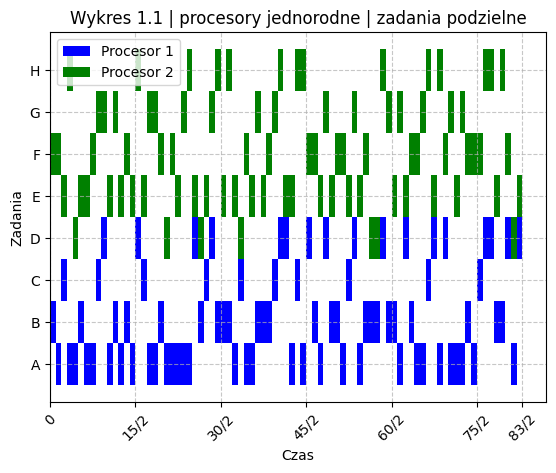

In [14]:
results: dict = ampl.var["v"].to_dict()
res_p1 = [(k[2],k[0]) for k,v in results.items() if k[1] == 1 and v == 1]
res_p2 = [(k[2],k[0]) for k,v in results.items() if k[1] == 2 and v == 1]

df_p1 = pd.DataFrame(res_p1)
df_p1[0] = df_p1[0] - 1
df_p2 = pd.DataFrame(res_p2)
df_p2[0] = df_p2[0] - 1

plt.barh(
    y=df_p1[1],
    width=1,
    left=df_p1[0],
    height=1,
    color="blue",
)

plt.barh(
    y=df_p2[1],
    width=1,
    left=df_p2[0],
    height=1,
    color="green",
)
plt.legend(["Procesor 1", "Procesor 2"])
plt.xticks([0, *[int(_) for _ in range(15,T,15)], T], ["0", *[f"{int(_)}/{K}" for _ in range(15,T,15)], f"{T}/{K}"], rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 1.1 | procesory jednorodne | zadania podzielne")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()

### Podsumowanie
Zadania podzielne w przypadku dwóch jednorodnych procesorów zostaną wykonane po czasie $Cmax=41.5$. w 82 skokach o długości 0.5 każda. 

## Zadanie 1.2 (a) Zadania niepodzielne <a name="z_1_2_a">
Mając dane: $n$ — liczba procesorów, $p_j$ — czas wykonania $j$-tego zadania, zapisać model minimalizujący czas wykonania wszystkich zadań (Cmax). Porównać wynik z rozwiązaniem, gdy zadania były podzielne. Jaka zależność zachodzi w ogólnym przypadku między rozwiązaniami tych zadań?

### Model matematyczny
##### Zbiory
$i = 1,...,n$ - zbór zadań
$l = 1,...,m$ - zbiór procesorów

##### Parametry
$p_i$ - czas potrzebny do wykonania zadania $i$

##### Zmienne decyzyjne
$v_{il}$ - Zmienna binarna oznaczająca, że zadanie $i$ zostanie wykonane na procesorze $l$  
$T$ - całkowity czas trwania harmonogramu

##### Ograniczenia  

Suma czasów zadań dla każdego procesora musi być mniejsza od maksymalnego czasu trwania harmonogramu
$$\sum\limits_{i} p_i v_{il} \leq T, \forall_l \quad (1.13)$$   

Jedno zadanie jest przyporządkowywane tylko do jednego procesora  
$$\sum\limits_{l} p_i v_{il} = p_i, \forall_i \quad (1.14)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$p_i \geq 0, \forall_i \quad (1.15)$$
$$v_{il} \geq 0, \forall{i,l} \quad (1.16)$$
$$T \geq 0, \quad (1.17)$$

##### Funkcja celu
Maksymalny czas zakończenia $C_{max}$
$$C{max} = min(T) \quad (1.17)$$

### AMPL implementacja

In [15]:
ampl.reset()

In [16]:
%%ampl_eval
# Sets
set Procesory;
set Zadania;

#======================================================================
# Params
param Czas_wyk{ Zadania } >= 0;

#======================================================================
# Vars
var v {Zadania, Procesory} >= 0 binary; # zmienna binarna która mówi ze dane zadanie zostało wykonane na danym procesorze
var T >= 0;

#======================================================================
# Constrains

# Ograniczenie minimalizujące czas dla Cmax 
subject to ogr_1_czas_zad_na_procesor {l in Procesory}:
    sum{i in Zadania} Czas_wyk[i]*v[i,l] <= T;


# jedno zadanie jest przyporządkowywane tylko do jednego procesora
subject to ogr_2_zadanie_wykonane {i in Zadania}:
    sum{l in Procesory} Czas_wyk[i]*v[i,l] = Czas_wyk[i];

#======================================================================
# Objective
minimize Cmax: T;

In [17]:
ampl.set["Zadania"] = czas_wykonania_zadan.keys()
ampl.set["Procesory"] = [x + 1 for x in range(liczba_procesorow)]
ampl.param["Czas_wyk"] = czas_wykonania_zadan

In [18]:
ampl.option["solver"] = "cplex"
ampl.solve()

CPLEX 22.1.1.0: optimal integer solution; objective 42
0 MIP simplex iterations
0 branch-and-bound nodes


### Przygotowanie danych python

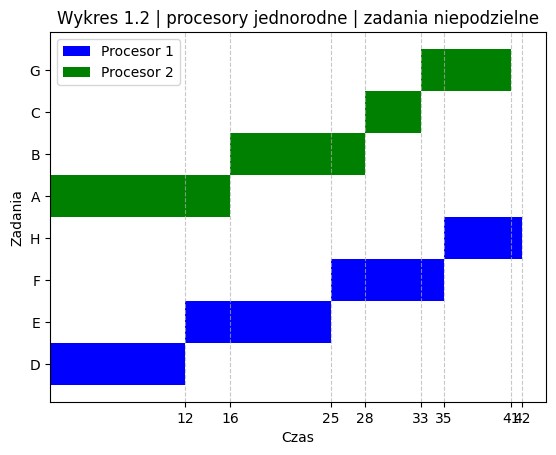

In [19]:
proc_zad = ampl.var["v"].to_dict()
results: dict[int, DataFrame] = {}
for n_proc in [1, 2]:
    proc = {k[0]:v*czas_wykonania_zadan[k[0]] for k,v in proc_zad.items() if k[1] == n_proc and v == 1}
    df_proc = pd.DataFrame(proc.values(), index=proc.keys(), columns=["czas_trwania"])
    df_proc["czas_zakonczenia"] = df_proc.cumsum(axis=0)
    df_proc["czas_rozpoczecia"] = df_proc["czas_zakonczenia"] - df_proc["czas_trwania"]
    
    results[n_proc] = df_proc
    
plt.barh(
    y=results[1].index,
    width=results[1].czas_trwania,
    left=results[1].czas_rozpoczecia,
    height=1,
    color="blue",
)

plt.barh(
    y=results[2].index,
    width=results[2].czas_trwania,
    left=results[2].czas_rozpoczecia,
    height=1,
    color="green",
)
plt.legend(["Procesor 1", "Procesor 2"])
plt.xticks(sorted([*results[1].czas_zakonczenia, *results[2].czas_zakonczenia]))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 1.2 | procesory jednorodne | zadania niepodzielne")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()

### Podsumowanie  
Porównując wynik otrzymany dla zadań niepodzielnych, przy procesorach jednorodnych otrzymujemy gorszy wynik wykonania wszystkich zadań Cmax. Dla zadań podzielnych otrzymaliśmy Cmax=41.5 a dla niepodzielnych Cmax=42. Wynik jest oczekiwany ponieważ w przypadku niemożliwości dzielenia zadań w większości przypadków (Zależy od danych) nie jesteśmy w stanie rozdzielić czasy zadań po równo między procesory.

## Zadanie 1.2 (b) Zadania niepodzielne <a name="z_1_2_b">
Zaproponować regułę przydziału zadań minimalizującą czas wykonania wszystkich zadań (Cmax). Porównać wynik z rozwiązaniem optymalnym - jaka zależność zachodzi w ogólnym przypadku?


Na podstawie wykładu E.Toczyłkowski 2007 wiemy, że dobrym algorytem przybliżonym jest metoda szeregowania listowego. Dla problemu $P||C_{max}$ najlepszym wariantem tego algorytmu jest LPT (longest processing time first). 

Mając tylko dane $n$ — liczba procesorów, $p_j$ — czas wykonania $j$-tego zadania zaimplementowałem algorytm LPT.

### Implementacji LSP algorytmu dla ograniczonego przypadku 2 procesorów 


In [20]:
zadania = czas_wykonania_zadan.copy()
sorted_zadania = [(k, v) for k, v in sorted(zadania.items(), key=lambda item: item[1], reverse=False)]
Proc = list[tuple[str, int, int, int]]
proc_1: Proc = []
proc_2: Proc = []

i = 0

while sorted_zadania:
    if not proc_1:
        proc_1.append(sorted_zadania.pop())
        continue
    
    if sum([_[1] for _ in proc_1]) == i:
        proc_1.append(sorted_zadania.pop())
        continue
        
    if not proc_2:
        proc_2.append(sorted_zadania.pop())
        continue
    
    if sum([_[1] for _ in proc_2]) == i:
        proc_2.append(sorted_zadania.pop())
        continue
    
    i+=1

for y in [proc_1, proc_2]:
    d = 0
    for i, x in enumerate(y):
        y[i] = (*x, d, d+x[1])
        d+=x[1]

    

### Przygotowanie danych python

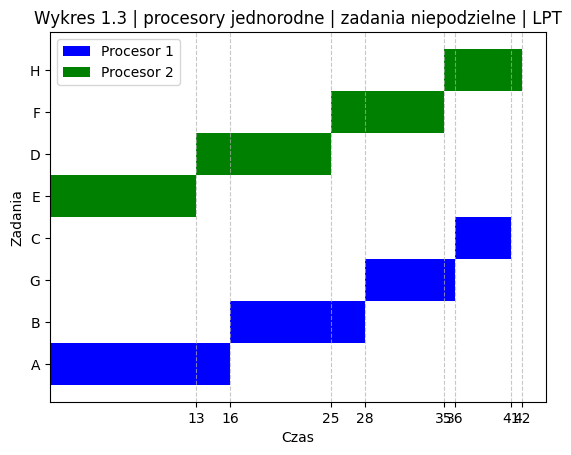

In [21]:
plt.barh(
    y=[_[0] for  _ in proc_1],
    width=[_[1] for  _ in proc_1],
    left=[_[2] for  _ in proc_1],
    height=1,
    color="blue",
)

plt.barh(
    y=[_[0] for  _ in proc_2],
    width=[_[1] for  _ in proc_2],
    left=[_[2] for  _ in proc_2],
    height=1,
    color="green",
)
plt.legend(["Procesor 1", "Procesor 2"])
plt.xticks(sorted([*[_[3] for  _ in proc_1], *[_[3] for  _ in proc_2]]))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 1.3 | procesory jednorodne | zadania niepodzielne | LPT")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()

### Podsumowanie
Czas $Cmax$ wyszedł taki sam dla obliczeń z podpunktu 1.2 (a) gdzie użyłem programowania liniowego, jak i przy prostym algorytmie LPT, który do wolnego procesora przyporządkowuje zadanie o najdłuższym czasie wykonania. W obydwu przypadkach $C_{max}=42$. Na podstawie wyników otrzymaych po wykonaniu obliczeń dla tylko moich danych można wnioskować że algorytm LPT dla przypadku $P||Cmax$ daje takie same rozwiązanie jak w programowaniu liniowym.

## Zadanie 1.2 (c) Zadania niepodzielne <a name="z_1_2_c">  
Mamy rozwiązanie — niekoniecznie optymalne. Zaproponuj algorytm lokalnej poprawy rozwiązania (zaproponuj algorytm dla ogólnego przypadku i pokaż, jak zadziała na Twoich danych).

### Podsumowanie
Rozwiązanie nieoptymalne dla problemu $P||\sum{C_i}$ otrzymamy np po użyciu algorytmu LPT (longest processing time first). Rozwiązanie będzie wtedy najlepsze dla problemu $P||Cmax$. Aby otrzymać optymalne rozwiązanie dla problemu $P||\sum{C_i}$ należy użyć algorytmu SPT

# Zadanie 2 <a name="z_2">  
Szeregowanie zadań na niejednorodnych procesorach równoległych

## Zadanie 2.1 (a) Zadania podzielne  <a name="z_2_1_a">  
Mając dane $p_{ij}$ — czas wykonania $j$-tego zadania na $i$-tym procesorze, zapisać model minimalizujący czas wykonania wszystkich zadań (Cmax) i przedstawić rozwiązanie.


### Model matematyczny
#### Faza numer 1
##### Zbiory
$i = 1,...,n$ - zbór zadań
$l = 1,...,m$ - zbiór procesorów

##### Parametry
$p_{il}$ - czas potrzebny do wykonania zadania $i$ na procesorze $l$  
  
##### Zmienne decyzyjne
$t_{il}$ - porcja operacji $i$ realizowana na procesorze $l$
$T$ - całkowity czas trwania harmonogramu

##### Ograniczenia  

Suma czasów dla każdego procesora jest mniejsza od całkowitego czasu trwania
$$\sum\limits_{i}t_{il} \leq T, \forall_l \quad (2.1)$$   

Suma czasów dla zadania jest mniejsza od całkowitego czasu trwania
$$\sum\limits_{l}t_{il} \leq T, \forall_i \quad (2.2)$$  

Ograniczenie wymuszające zrealizowanie każdej operacji  
$$\sum\limits_{l}t_{il}/p_{il}=1, \forall_i \quad (2.3)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$p_{il} \geq 0, \forall_{i,l} \quad (2.4)$$
$$t_{il} \geq 0, \forall_{i,l} \quad (2.5)$$
$$T \geq 0, \quad (2.6)$$

##### Funkcja celu
Maksymalny czas zakończenia $C_{max}$
$$C{max} = min(T) \quad (2.7)$$


#### Faza numer 2  

##### Zbiory
$i = 1,...,n$ - zbór zadań  
$l = 1,...,m$ - zbiór procesorów  
$t = 1,...,T$ - zbiór etapów/kwatów  

##### Parametry
$t_{il}$ - porcja operacji $i$ realizowana na procesorze $l$
$K$ -  współczynnik skali, pozwalający operować na całkowitoliczboych kwantach czasu harmonogramu.
$T$ - całkowity czas trwania harmonogramu w skali długości trwania pojedynczego etapu, tj. $T= C_{max}\cdot K$.

##### Zmienne decyzyjne
$v_{ilt}$ - Zmienna binarna oznaczająca że porcja operacji $i$ realizowana na procesorze $j$ w chwili/kwancie $t$.  Możliwa do użycia po wprowadzeniu $K$  

##### Ograniczenia
Ograniczenie na liczbę zadań obsługiwanych na procesorze w jednym etapie:
$$\sum_{i}v_{ilt} \leq 1,\quad ∀_{l,t}. \quad (2.8)$$

Ograniczenie na liczbę procesorów pracujących nad zadaniem w jednym etapie:
$$\sum_{l}v_{ilt} \leq 1,\quad ∀_{i,t}. \quad (2.9)$$

Ograniczenie wymuszające zrealizowanie wszystkich porcji zadań na przypisanych im procesorach:
$$\sum_{t}v_{ilt}=t_{il} K  ,\quad ∀_{i,l}. \quad (2.10)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$K \geq 0, \quad (2.11)$$
$$T \geq 0, \quad (2.12)$$
$$t_{il} \geq 0, \forall_{i,l} \quad (2.13)$$
$$v_{ilt} \geq 0,\quad \forall_{i,l,t} \quad (2.14)$$ 

##### Funkcja celu
W zadaniu 2 Fazy w zasadzie brak funkcji celu, interesuje nas jedynie znalezienie rozwiązania harmonogramu, którego długość jest już znana. Czyli w problemie tym istotne są tylko ograniczenia.

### Dane

In [22]:
Procesory = ["1", "2"]
Zadania_indexy = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

ZadaniaDataFrame = pd.DataFrame(
        np.array(
            [
                [14, 9],
                [14, 16],
                [5, 7],
                [11, 9],
                [14, 12],
                [12, 16],
                [8, 5],
                [9, 17],
            ]
        ),
        columns=Procesory,
        index=Zadania_indexy,
    )

### AMPL implementacja Faza 1

In [23]:
ampl.reset()


In [24]:
%%ampl_eval
# Sets
set Procesory;
set Zadania;

#======================================================================
# Params
param Czas_wyk{ Zadania, Procesory } >= 0;

#======================================================================
# Vars
var t{ Zadania, Procesory} >= 0;
var T >= 0;

#======================================================================
# Constrains

subject to ogr_1_zad_na_procesor {l in Procesory}:
    sum{i in Zadania} t[i,l] <= T;

subject to ogr_2_procesor_na_zadanie {i in Zadania}:
    sum{l in Procesory} t[i,l] <= T;

subject to ogr_3_pelne_wyk_zadania {i in Zadania}:
    sum{l in Procesory} (t[i,l]/Czas_wyk[i,l]) = 1;

#======================================================================
# Objective
minimize Cmax: T;

In [25]:
ampl.set["Procesory"] = ZadaniaDataFrame.columns
ampl.set["Zadania"] = ZadaniaDataFrame.index
ampl.param["Czas_wyk"] = ZadaniaDataFrame


In [26]:
# Solve the problem
ampl.option["solver"] = "highs"
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution; objective 37.66666667
4 simplex iterations
0 barrier iterations


In [27]:
ampl.option["display_1col"] = 0
ampl.display("t")

t [*,*]
:     '1'       '2'       :=
A    0         9
B   11.6667    2.66667
C    5         0
D    0         9
E    0        12
F   12         0
G    0         5
H    9         0
;



Otrzymaliśmy ułamkowe porcje realizacji zadań - aby móc wyznaczyć harmonogram potrzebujemy przeskalować wyniki mnożąc je przez 3, co będzie oznaczało, że etapy harmonogramu mają długość 1/3. Horyzont planowania wynosi Cmax*3.

In [28]:
K = 3
Cmax = (ampl.obj["Cmax"].value())
T = round(K * Cmax)
print(f"Cmax={Cmax}, K={K}, T={T}")

Cmax=37.66666666666667, K=3, T=113


In [29]:
Zadania = ampl.set['Zadania'].get_values().to_dict().keys()
Procesory = ampl.set['Procesory'].get_values().to_dict().keys()
Cmax: float = ampl.obj['Cmax'].value()
porcjeZadan: dict = ampl.var["t"].to_dict()

### AMPL implementacja Faza 2

In [30]:
ampl.reset()

In [31]:
%%ampl_eval
set Procesory;
set Zadania;
#======================================================================
param Cmax;
param Kwant;
set Kwanty := 1..round(Cmax*Kwant);
param Porcje { Zadania, Procesory} >= 0;

#======================================================================
var v{Zadania, Procesory, Kwanty}>=0;
#======================================================================
subject to

	Ogr_Praca_procesora{l in Procesory, t in Kwanty}:
		sum {i in Zadania} v[i,l,t]<=1;

	Ogr_Obsluga_zadania{i in Zadania, t in Kwanty}:
		sum{l in Procesory} v[i,l,t]<=1;

	Ogr_Rozdzial_zadan{i in Zadania, l in Procesory}:
		sum{t in Kwanty} v[i,l,t]=round(Porcje[i,l]*Kwant);

In [32]:
ampl.set["Zadania"] = Zadania
ampl.set["Procesory"] = Procesory
ampl.param["Cmax"] = Cmax
ampl.param["Kwant"] = K
ampl.param["Porcje"] = porcjeZadan

In [33]:
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution
731 simplex iterations
0 barrier iterations
Objective = find a feasible point.


### Przygotowanie danych python

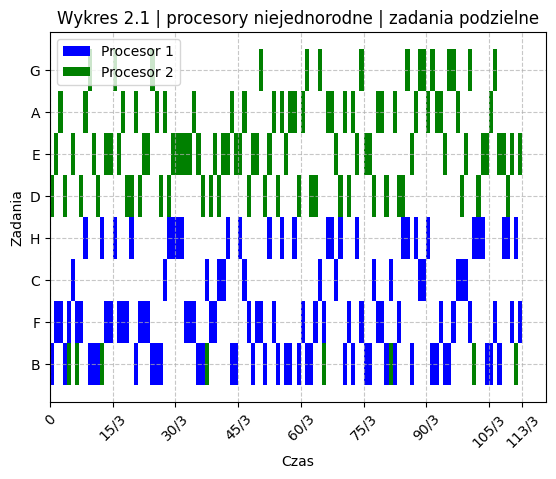

In [34]:
results: dict = ampl.var["v"].to_dict()
res_p1 = [(k[2], k[0]) for k, v in results.items() if k[1] == '1' and v == 1]
res_p1 = sorted(res_p1, key=lambda x: x)

res_p2 = [(k[2], k[0]) for k, v in results.items() if k[1] == "2" and v == 1]
res_p2.sort(key=lambda x: x)

df_p1 = pd.DataFrame(res_p1)
df_p1[0] = df_p1[0] - 1
df_p2 = pd.DataFrame(res_p2)
df_p2[0] = df_p2[0] - 1

plt.barh(
    y=df_p1[1],
    width=1,
    left=df_p1[0],
    height=1,
    color="blue",
)

plt.barh(
    y=df_p2[1],
    width=1,
    left=df_p2[0],
    height=1,
    color="green",
)
plt.legend(["Procesor 1", "Procesor 2"])
plt.xticks([0, *[int(_) for _ in range(15,T,15)], T], ["0", *[f"{int(_)}/{K}" for _ in range(15,T,15)], f"{T}/{K}"], rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 2.1 | procesory niejednorodne | zadania podzielne")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()

## Zadanie 2.1 (b) Zadania podzielne  <a name="z_2_1_b">  
Zapisać model i wyznaczyć harmonogram zakładając, że każdy z procesorów może wykonywać jedno lub dwa zadania jednocześnie

### Model matematyczny
#### Faza numer 1
##### Zbiory
$i = 1,...,n$ - zbór zadań
$l = 1,...,m$ - zbiór procesorów  
$w = 1,...,W$ - zbiór wątków dla jednego procesora

##### Parametry
$p_{il}$ - czas potrzebny do wykonania zadania $i$ na procesorze $l$
$W$ - parametr definiowany przez użytkownika oznaczający ilość wątków dla procesora.  
  
##### Zmienne decyzyjne
$t_{ilw}$ - porcja operacji $i$ realizowana na procesorze $l$, przez watek $w$  
$T$ - całkowity czas trwania harmonogramu

##### Ograniczenia  

Suma czasów dla każdego wątku jest mniejsza od całkowitego czasu trwania
$$\sum\limits_{i}t_{ilw} \leq T, \forall_{l,w} \quad (2.15)$$   

Suma czasów dla zadania jest mniejsza od całkowitego czasu trwania
$$\sum_{l}t_{ilw} \leq T, \forall_{i,w} \quad (2.16)$$  

Ograniczenie wymuszające zrealizowanie każdej operacji  
$$\sum_{l}\sum_{w} t_{ilw}/p_{il}=1, \forall_i \quad (2.17)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$p_{il} \geq 0, \forall_{i,l} \quad (2.18)$$
$$t_{il} \geq 0, \forall_{i,l} \quad (2.19)$$
$$T \geq 0, \quad (2.20)$$
$$W \geq 1, \quad (2.21)$$

##### Funkcja celu
Maksymalny czas zakończenia $C_{max}$
$$C{max} = min(T) \quad (2.22)$$

#### Faza numer 2  

##### Zbiory
$i = 1,...,n$ - zbór zadań  
$l = 1,...,m$ - zbiór procesorów  
$t = 1,...,T$ - zbiór etapów/kwatów  
$w = 1,...,W$ - zbiór wątków dla jednego procesora


##### Parametry
$t_{ilw}$ - porcja operacji $i$ realizowana na procesorze $l$, przez wątek $w$    
$K$ - współczynnik skali, pozwalający operować na całkowitoliczboych kwantach czasu harmonogramu.  
$T$ - całkowity czas trwania harmonogramu w skali długości trwania pojedynczego etapu, tj. $T= C_{max}\cdot K$.  
$W$ - parametr definiowany przez użytkownika w fazie 1.  Ilość wątków dla jednego procesora.    

##### Zmienne decyzyjne
$v_{iltw}$ - Zmienna binarna oznaczająca że porcja operacji $i$ realizowana na procesorze $j$  przez wątek $w$ w chwili/kwancie $t$.  Możliwa do użycia po wprowadzeniu $K$    

##### Ograniczenia
Ograniczenie na liczbę zadań obsługiwanych na jedym wątku w jednym etapie:  
$$\sum_{i}v_{iltw} \leq 1,\quad ∀_{l,t,w}. \quad (2.23)$$  

Ograniczenie na liczbę wątków pracujących nad zadaniem w jednym etapie:  
$$\sum_{l}\sum_{w}v_{iltw} \leq 1,\quad ∀_{i,t}. \quad (2.24)$$  

Ograniczenie wymuszające zrealizowanie wszystkich porcji zadań na przypisanych im wątkach:  
$$\sum_{t}v_{iltw}=t_{ilw} K  ,\quad ∀_{i,l,w}. \quad (2.25)$$    
  
Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera  
$$K \geq 0, \quad (2.26)$$  
$$T \geq 0, \quad (2.27)$$  
$$t_{ilw} \geq 0, \forall_{i,l,w} \quad (2.28)$$  
$$v_{iltw} \geq 0,\quad \forall_{i,l,t,w} \quad (2.29)$$   
$$W \geq 1, \quad (2.30)$$  

##### Funkcja celu
W zadaniu 2 Fazy w zasadzie brak funkcji celu, interesuje nas jedynie znalezienie rozwiązania harmonogramu, którego długość jest już znana. Czyli w problemie tym istotne są tylko ograniczenia.

### AMPL implementacja Faza 1

In [35]:
ampl.reset()

In [36]:
%%ampl_eval
# Sets Params
set Zadania;
set Procesory;
param MaxWatekPerProcesor >= 1;
set Watki := 1..MaxWatekPerProcesor; # watki procesora

param Czas_wyk{ Zadania, Procesory} >= 0;

#======================================================================
# Vars
var t{ Zadania, Procesory, Watki} >= 0; # czas zadania na procesorze 

var T >= 0;

#======================================================================
# Constrains
subject to ogr_1_zad_na_procesor {l in Procesory, w in Watki}:
    sum{i in Zadania} t[i,l,w] <= T;

subject to ogr_2_procesor_na_zadanie {i in Zadania, w in Watki}:
    sum{l in Procesory} t[i,l,w] <= T;

# Ograniczenie wymuszające zrealizowanie wszystkich porcji zadań na przypisanych im procesorach:
subject to ogr_3_wyk_zadania {i in Zadania}:
    sum{l in Procesory, w in Watki} (t[i,l,w]/Czas_wyk[i,l]) = 1;

#======================================================================
# Objective
minimize Cmax: T;

In [37]:
MaxWatekPerProcesor = 2

In [38]:
ampl.set["Procesory"] = ZadaniaDataFrame.columns
ampl.set["Zadania"] = ZadaniaDataFrame.index
ampl.param["Czas_wyk"] = ZadaniaDataFrame
ampl.param["MaxWatekPerProcesor"] = MaxWatekPerProcesor

In [39]:
# Solve the problem
ampl.option["solver"] = "highs"
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution; objective 18.83333333
18 simplex iterations
0 barrier iterations


In [40]:
ampl.option["display_1col"] = 0
ampl.display("t")
ampl.display("Cmax")


t [*,'1',*]
:      1          2       :=
A    0         0
B    6.83333   4.83333
C    0         5
D    0         0
E    0         0
F   12         0
G    0         0
H    0         9

 [*,'2',*]
:      1          2       :=
A    0         9
B    0         2.66667
C    0         0
D    1.83333   7.16667
E   12         0
F    0         0
G    5         0
H    0         0
;

Cmax = 18.8333



Otrzymaliśmy ułamkowe porcje realizacji zadań - aby móc wyznaczyć harmonogram potrzebujemy przeskalować wyniki mnożąc je przez 6, co będzie oznaczało, że etapy harmonogramu mają długość 1/6. Horyzont planowania wynosi Cmax*6.

In [41]:
K = 3 * MaxWatekPerProcesor
Cmax = (ampl.obj["Cmax"].value())
T = round(K * Cmax)
print(f"Cmax={Cmax}, K={K}, T={T}")

Cmax=18.83333333333333, K=6, T=113


In [42]:
Zadania = ampl.set['Zadania'].get_values().to_dict().keys()
Procesory = ampl.set['Procesory'].get_values().to_dict().keys()
Watki = ampl.set['Watki'].get_values().to_dict().keys()
porcjeZadan: dict = ampl.var["t"].to_dict()

### AMPL implementacja Faza 2

In [43]:
ampl.reset()

In [44]:
%%ampl_eval
set Procesory;
set Zadania;
set Watki;
#======================================================================
param Cmax;
param Kwant;
set Kwanty := 1..round(Cmax*Kwant);
param Porcje { Zadania, Procesory, Watki} >= 0;

#======================================================================
var v{Zadania, Procesory, Watki, Kwanty}>=0;
#======================================================================
subject to

	Ogr_Praca_procesora{l in Procesory, w in Watki, t in Kwanty}:
		sum {i in Zadania} v[i,l,w,t]<=1;

	Ogr_Obsluga_zadania{i in Zadania, t in Kwanty}:
		sum{l in Procesory, w in Watki} v[i,l,w,t]<=1;

	Ogr_Rozdzial_zadan2{i in Zadania,l in Procesory, w in Watki}:
		sum{t in Kwanty} v[i,l,w,t]=round(Porcje[i,l,w]*Kwant);

In [45]:
ampl.set["Zadania"] = Zadania
ampl.set["Procesory"] = Procesory
ampl.set["Watki"] = Watki
ampl.param["Cmax"] = Cmax
ampl.param["Kwant"] = K
ampl.param["Porcje"] = porcjeZadan

In [46]:
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution
1229 simplex iterations
0 barrier iterations
Objective = find a feasible point.


### Przygotowanie danych python

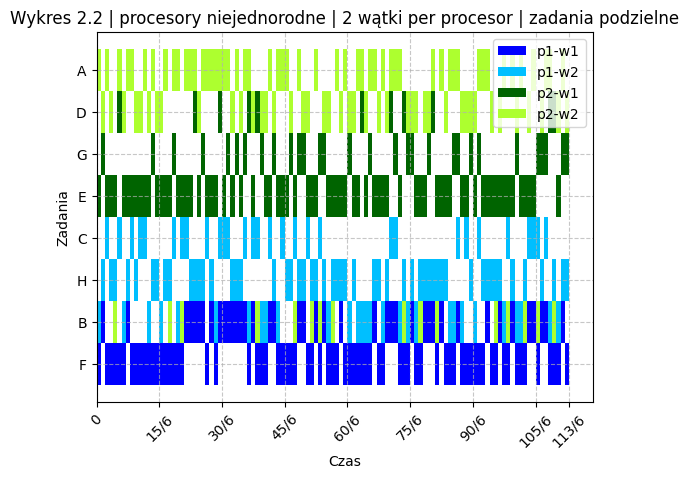

In [47]:
results: dict = ampl.var["v"].to_dict()
res: dict = {}

colors = {
    "p1-w1": "blue",
    "p1-w2": "deepskyblue",
    "p2-w1": "darkgreen",
    "p2-w2": "greenyellow",
}

for p in Procesory:
    for w in Watki:
        tmp = [(k[3], k[0]) for k, v in results.items() if k[1] == p and k[2] == w and v == 1]
        tmp = sorted(tmp, key=lambda x: x)
        tmp_df = pd.DataFrame(tmp)
        tmp_df[0] = tmp_df[0] - 1
        res[f"p{p}-w{w}"] = tmp_df
        
        plt.barh(
            y=tmp_df[1],
            width=1,
            left=tmp_df[0],
            height=1,
            color=colors[f"p{p}-w{w}"],
        )
        
plt.legend(res.keys())
plt.xticks([0, *[int(_) for _ in range(15,T,15)], T], ["0", *[f"{int(_)}/{K}" for _ in range(15,T,15)], f"{T}/{K}"], rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 2.2 | procesory niejednorodne | 2 wątki per procesor | zadania podzielne")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()        

### Podsumowanie  
Dodając warunek, że każdy z niejednorodnych procesorów może wykonywać dwa zadania jednocześnie zmniejszamy czas Cmax o połowe w przypadku podzielnych zadań. Zadanie można wyjkonać dwojako. Podzielić procesory na wątki, lub stwierdzić że pula procesorów składa się z 4 jednostek, przy czym każda para jest identyczna. $Cmax=18.83$ dla dwóch wątków dla jedengo proesora.  
 

## Zadanie 2.2 (a) Zadania niepodzielne  <a name="z_2_2_a">
Mając dane $p_{ij}$ — czas wykonania $j$-tego zadania na $i$-tym procesorze, zapisać model minimalizujący czas wykonania wszystkich zadań ($Cmax$).

### Model matematyczny
##### Zbiory
$i = 1,...,n$ - zbór zadań
$l = 1,...,m$ - zbiór procesorów

##### Parametry
$p_{il}$ - czas potrzebny do wykonania zadania $i$ przez procesor $l$  

##### Zmienne decyzyjne
$v_{il}$ - Zmienna binarna oznaczająca, że zadanie $i$ zostanie wykonane na procesorze $l$  
$T$ - całkowity czas trwania harmonogramu

##### Ograniczenia  

Suma czasów zadań dla każdego procesora musi być mniejsza od maksymalnego czasu trwania harmonogramu
$$\sum_{i} p_{il} v_{il} \leq T, \forall_l \quad (2.31)$$   

Suma czasów pracy każdego procesora musi być mniejsza od maksymalnego czas trwania harmonogramu  
$$\sum_{l} p_{il} v_{il} \leq T, \forall_i \quad (2.32)$$

Każde zadanie musi zostac wykonane tylko przez jeden procesor  
$$\sum_{l} v_{il} = 1, \forall_i \quad (2.33)$$  

Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$p_i \geq 0, \forall_i \quad (2.34)$$
$$ 0 \leq v_{il} \leq 1, \forall_{i,l} \quad (2.35)$$
$$T \geq 0, \quad (2.36)$$

##### Funkcja celu
Maksymalny czas zakończenia $C_{max}$
$$C{max} = min(T)  \quad (2.37)$$

### AMPL implementacja

In [48]:
ampl.reset()

In [49]:
%%ampl_eval
# Sets
set Procesory;
set Zadania;

#======================================================================
# Params
param Czas_wyk{ Zadania, Procesory } >= 0;

#======================================================================
# Vars
var v {Zadania, Procesory} >= 0 binary; # zmienna binarna która mówi ze dane zadanie zostało wykonane na danym procesorze
var T >= 0;

#======================================================================
# Constrains

# Ograniczenie minimalizujące czas dla Cmax 
subject to ogr_1_czas_zad_na_procesor {l in Procesory}:
    sum{i in Zadania} Czas_wyk[i,l]*v[i,l] <= T;

subject to ogr_2_procesor_na_zadanie {i in Zadania}:
    sum{l in Procesory} Czas_wyk[i,l]*v[i,l] <= T;

# Każde zadanie musi zostać wykonane przez jeden procesor
subject to ogr_3_zadanie_wykonane {i in Zadania}:
    sum{l in Procesory} v[i,l] = 1;


#======================================================================
# Objective
minimize Cmax: T;

In [50]:
ampl.set["Procesory"] = ZadaniaDataFrame.columns
ampl.set["Zadania"] = ZadaniaDataFrame.index
ampl.param["Czas_wyk"] = ZadaniaDataFrame

In [51]:
ampl.option["solver"] = "cplex"
ampl.solve()

CPLEX 22.1.1.0: optimal integer solution; objective 40
8 MIP simplex iterations
0 branch-and-bound nodes


### Przygotowanie danych python

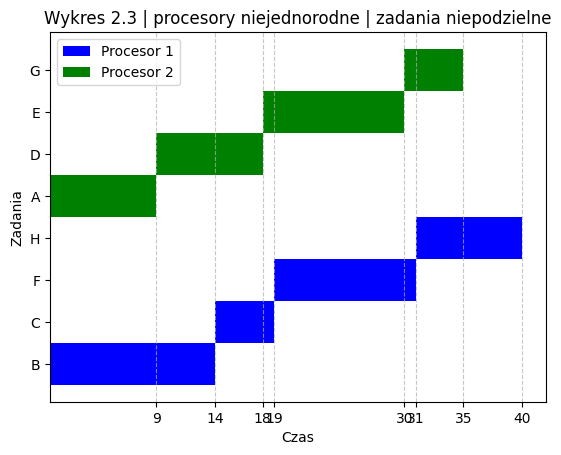

In [52]:
proc_zad = ampl.var["v"].to_dict()
results: dict[str, DataFrame] = {}
for n_proc in ["1", "2"]:
    proc = {k[0]: v * ZadaniaDataFrame.loc[k[0], n_proc] for k, v in proc_zad.items() if k[1] == n_proc and v == 1}
    df_proc = pd.DataFrame(proc.values(), index=proc.keys(), columns=["czas_trwania"])
    df_proc["czas_zakonczenia"] = df_proc.cumsum(axis=0)
    df_proc["czas_rozpoczecia"] = df_proc["czas_zakonczenia"] - df_proc["czas_trwania"]

    results[n_proc] = df_proc
    
plt.barh(
    y=results['1'].index,
    width=results['1'].czas_trwania,
    left=results['1'].czas_rozpoczecia,
    height=1,
    color="blue",
)

plt.barh(
    y=results['2'].index,
    width=results['2'].czas_trwania,
    left=results['2'].czas_rozpoczecia,
    height=1,
    color="green",
)
plt.legend(["Procesor 1", "Procesor 2"])
plt.xticks(sorted([*results['1'].czas_zakonczenia, *results['2'].czas_zakonczenia]))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 2.3 | procesory niejednorodne | zadania niepodzielne")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()

### Podsumowanie
Czas $Cmax$ dla niejednorodnych procesorów przy zadaniach niepodzielnych wynosi 40. W porównaniu do wyniku 37.66 przy zdaniach podzielnych. Wynik jest oczekwiwany.  

## Zadanie 2.2 (b) Zadania podzielne  <a name="z_2_2_b">
Mając dane $p_{il}$ — czas wykonania i-tego zadania na l-tym procesorze, zapisać model minimalizujący sumę czasów przebywania w systemie (∑ Fi ).

Ze wzoru podanego w wykładach wiemy że:  
$$F_i=C_i-r_i \quad (2.38)$$  
Oraz na podstawie wykładów wiemy, że aby zminimalizować (∑ Fi) należy użyć reguły SPT 

Wiedząc ze w tym przypadku $F_i=C_i-r_i$, $r_i=0$ bo wszystkie zadania sa gotowe do wykoniania od pierwszej chwili to obliczenie czasów przebywania w systemie sprowadzi się tylko do obliczenia $\sum{C_i}$ (suma czasów zakończenia)
 

### Model Matematyczny
##### Zbiory
$i = 1,...,n$ - zbór zadań  
$l = 1,...,m$ - zbiór procesorów  
$j = 1,...,o$ - zbiór okien wykonania zadania od końca. To znaczy że dla $j$ = 1,..4 są czetery okienka. j=1 oznacza ostanie okienko, a j=4, że pierwsze okienko.  
 
### Parametry
$p_{il}$ - Czas potrzebny przez niejednorodny procesor $l$ na wykonanie zadania $i$  

### Zmienne decyzyjne 
$v_{ilj}$ - zmienna binarna oznaczająca, że zadanie $i$ zostało wykonane przez procesor $l$ podczas okienka $j$.  

### Ograniczenia  
Każde zadanie musi zostać wykonane przez jeden procesor i w jednym okienku czasowym.  
$$\sum_{l}\sum_{j} v_{ilj} = 1, \forall_{i}  \quad (2.39)  $$

Na jednym procesorze w jednym oknie czasowym nie zostało wykonane więcej niż jedno zadanie
$$ \sum_{i} v_{ilj} <= 1, \forall_{l,j}  \quad (2.40) $$

### Funkcja celu  
Minimalizacja sumy czasów wykonania zadań na wszystkich procesorach pomnożona przez numer okienka od końca $j$ na którym zostało wykonane.  
$$F_i=min(\sum_{ilj} j*p_{il}*v_{ilj}) \quad (2.41) $$

### AMPL implementacja

In [53]:
ampl.reset()

In [54]:
%%ampl_eval
# Sets
set Procesory;
set Zadania;
set Okna; # j pozycja zadania od końca!!!
#======================================================================
# Params
param Czas_wyk{ Zadania, Procesory } >= 0;

#======================================================================
# Vars
var v {Zadania, Procesory, Okna} >= 0 binary; # zmienna binarna, która mówi ze dane zadanie zostało wykonane na danym procesorze

# Każde zadanie musi zostać wykonane przez jeden procesor
subject to ogr_kazde_zadanie_wykonane_przez_jeden_procesor {i in Zadania}:
    sum{l in Procesory, j in Okna} v[i,l,j] = 1;

# Na jednym procesorze w jednym oknie czasowym nie zostało wykonane więcej niż jedno zadanie
subject to ogr_procesor_okno_ma_max_jedno_zadanie {l in Procesory, j in Okna}:
    sum{i in Zadania} v[i,l,j] <= 1;

#======================================================================
# Objective
minimize Fi: sum{i in Zadania, l in Procesory, j in Okna} j*Czas_wyk[i,l]*v[i,l,j];

In [55]:
ampl.set["Procesory"] = ZadaniaDataFrame.columns
ampl.set["Zadania"] = ZadaniaDataFrame.index
x: list = [i for i, zad in  enumerate(Zadania, 1)]
ampl.set["Okna"] = x
ampl.param["Czas_wyk"] = ZadaniaDataFrame


In [56]:
# ampl.option["solver"] = "highs"
ampl.option["solver"] = "cplex"
ampl.solve()


CPLEX 22.1.1.0: optimal integer solution; objective 162
13 MIP simplex iterations
0 branch-and-bound nodes


### Przygotowanie danych python

In [57]:
results = ampl.var["v"].to_list()
result = namedtuple("result", ["Zadanie", "Proces", "Okna", "v", "Czas_wyk", "Czas_przebywania"] )
results: list[result] = [result(*_, ZadaniaDataFrame.loc[_[0],_[1]], 0) for _ in results]
results_2b = [_ for _ in results if _.v == 1]
df_results_2b = pd.DataFrame(results_2b)

df_results_2b = df_results_2b.sort_values(by=["Proces", "Okna"], ascending=[True, False])
df_results_2b['Czas_przebywania'] = df_results_2b.groupby(["Proces"], sort=True)["Czas_wyk"].cumsum()
df_results_2b['Czas_rozpoczecia'] = df_results_2b["Czas_przebywania"] - df_results_2b["Czas_wyk"]
df_results_2b_p1 = df_results_2b[df_results_2b["Proces"] == "1"]
df_results_2b_p2 = df_results_2b[df_results_2b["Proces"] == "2"]

df_results_2b.set_index("Zadanie").head(10)

,Proces,Okna,v,Czas_wyk,Czas_przebywania,Czas_rozpoczecia
Zadanie,,,,,,
C,1,4,1,5,5,0
H,1,3,1,9,14,5
F,1,2,1,12,26,14
B,1,1,1,14,40,26
G,2,4,1,5,5,0
D,2,3,1,9,14,5
A,2,2,1,9,23,14
E,2,1,1,12,35,23


In [58]:
SumCzasPrzebywania = df_results_2b["Czas_przebywania"].sum()
print(f"Suma czasów przebywania w systemie = {SumCzasPrzebywania}")

Suma czasów przebywania w systemie = 162


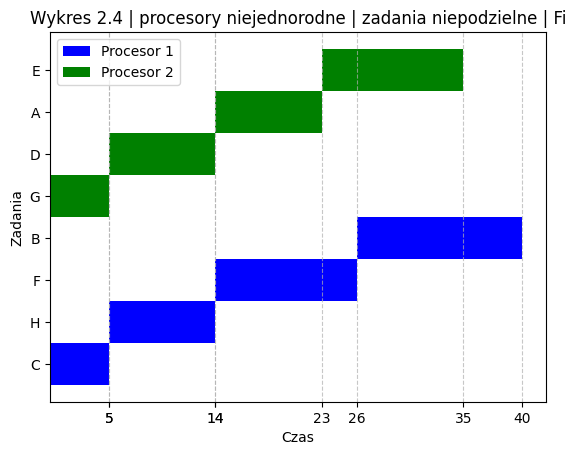

In [59]:

plt.barh(
    y=df_results_2b_p1.Zadanie,
    width=df_results_2b_p1.Czas_wyk,
    left=df_results_2b_p1.Czas_rozpoczecia,
    height=1,
    color="blue",
)

plt.barh(
    y=df_results_2b_p2.Zadanie,
    width=df_results_2b_p2.Czas_wyk,
    left=df_results_2b_p2.Czas_rozpoczecia,
    height=1,
    color="green",
)
plt.legend(["Procesor 1", "Procesor 2"])
plt.xticks(sorted([*df_results_2b_p1.Czas_przebywania, *df_results_2b_p2.Czas_przebywania]))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Wykres 2.4 | procesory niejednorodne | zadania niepodzielne | Fi")
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.show()

### Podsumowanie
Suma czasów przebywania w systemie $\sum{F_i}=162$

## Zadanie 2.2 (c) Zadania podzielne  <a name="z_2_2_c">
Mając dane $p_{ji}$ — czas wykonania j-tego zadania na i-tym procesorze, zapisać model minimalizujący sumę czasów oczekiwania na obsługę. Wskazówka - zastanowić się, czym się różni ten podpunkt od poprzed- niego.


$$F_j=C_j-r_j \quad (2 .41) $$  
$F_j$ - Czas przebywania w systemie   
$C_j$ - Chwila ukończenia zadania zadania  
$r_j$ - Chwila gotowości zadania do obsługi, przy czym  gdy wszystkie zadania są odrazu gotowe do obslugi $r_j=0$  
  

$$W_j=F_j-p_j=C_j-r_j-p_j \quad (2.42)$$  
$W_j$ - Oczekiwanie na obsługe  
$p_j$ - Czas oitrzebny na wykonanie zadania  


Analizując dwa powyższe równania i wiedząc, że $r_j=0$ wiemy, że aby otrzymać sume czasów oczekiwania na obsługę należy od wyniku z zadania 2.2 (b) gdzie obliczyliśmy $\sum{F_i}$ odjąć sumę czasów wykonania wszystkich zadań

### Model Matematyczny

Aby otrzymać sumę czasów oczekiwania na obsługę $W_j$ należy tylko zmidyfikować fukcje celu z podpunktu (2.2 b). Od funkcji celu należy odjąc sumę czasów potrzebnych do wykonania zadania $p_j$ pomnożone przez zmienną binarną $v_{ilj}$.

### Funkcja celu  
Minimalizacja sumy czasów wykonania zadań na wszystkich procesorach pomnozona przez numer okienka $j$ na którym zostało wykonane. Od sumy zostaje odjęty czas wykonia zadania $i$  
$$F_i=min(\sum_{ilj} j*p_{il}*v_{ilj} - p_{il}*v_{ilj}) \quad (2.43) $$

In [60]:
ampl.reset()

In [61]:
%%ampl_eval
# Sets
set Procesory;
set Zadania;
set Okna;
#======================================================================
# Params
param Czas_wyk{ Zadania, Procesory } >= 0;

#======================================================================
# Vars
var v {Zadania, Procesory, Okna} >= 0 binary; # zmienna binarna która mówi ze dane zadanie zostało wykonane na danym procesorze

# Każde zadanie musi zostać wykonane przez jeden procesor
subject to ogr_kazde_zadanie_wykonane_przez_jeden_procesor {i in Zadania}:
    sum{l in Procesory, j in Okna} v[i,l,j] = 1;

subject to ogr_procesor_okno_ma_max_jedno_zadanie {l in Procesory, j in Okna}:
    sum{i in Zadania} v[i,l,j] <= 1;


#======================================================================
# Objective
minimize Fi: sum{i in Zadania, l in Procesory, j in Okna} (j*Czas_wyk[i,l]*v[i,l,j] - Czas_wyk[i,l]*v[i,l,j]);

In [62]:
ampl.set["Procesory"] = ZadaniaDataFrame.columns
ampl.set["Zadania"] = ZadaniaDataFrame.index
ampl.set["Okna"] = [i for i, zad in enumerate(Zadania, 1)]
ampl.param["Czas_wyk"] = ZadaniaDataFrame

In [63]:
ampl.option["solver"] = "cplex"
ampl.solve()

CPLEX 22.1.1.0: optimal integer solution; objective 87
25 MIP simplex iterations
0 branch-and-bound nodes


### Podsumowanie
Czas przebywania w systemie oraz czas oczekiwania na wykonanie dają ten sam harmonogram. Różnią się między sobą tylko suma czasu potrzebną do wykonania wszystkich zadań 162 - 75 = 87, gdzie 75 to czas potrzebny na wykonanie wszystkich zadań.


# Zadanie 3 <a name="z_3">
W tym zadaniu celem jest zaplanowanie produkcji. Dane jest zapotrzebowanie na produkty końcowe, które należy zaspokoić pod koniec określonych okresów czasu. Do wytworzenia poszczególnych produktów potrzebne są pół-produkty.  

Wytworzenie poszczególnych produktów i podproduktów wymaga określonego czasu, oraz wiąże się z kosztami stałymi. Koszt stały jest ponoszony bez względu na wytwarzaną ilość w każdym etapie, w którym inicjujemy produkcję, tzn. gdy w danym etapie są pobierane półprodukty potrzebne do produkcji.  

Produkty i półprodukty są dostępne po okresie równym czasowi produkcji. Jeżeli nie zostaną wykorzystane/przekazane w etapie, w którym zakończono ich produkcję to muszą być magazynowane, co wiąże się z kosztami magazynowania.  

Należy określić, ile i kiedy produkować oraz magazynować poszczególne produkty i półprodukty.

## Zadanie 3 (a) <a name="z_3_a">  
Stwórz i rozwiąż model, opisujący warstwę wyrobów finalnych (koszty i czas wytworzenia półproduktów pomijamy i zakładamy, że są one dostępne w odpowiednich ilościach);

In [64]:
# Data
Produkty: list[str] = ["A", "B", "C", "D", "E", "F", "G", "H"]
Okresy: list[int] = [1,2,3,4,5,6,7,8,9]

CzasProdukcji = {
    "A": 1,
    "B": 2,
    "C": 1,
    "D": 1,
    "E": 3,
    "F": 1,
    "G": 1,
    "H": 2,
}
KosztUruchomProdukcji = {
    "A": 20,
    "B": 12,
    "C": 15,
    "D": 7,
    "E": 5,
    "F": 2,
    "G": 19,
    "H": 9,
}
KosztMagazynowania = {
    "A": 4,
    "B": 2,
    "C": 2,
    "D": 1,
    "E": 1,
    "F": 1,
    "G": 1,
    "H": 2,
}

ZapotrzebowanieDF = pd.DataFrame(
        np.array(
            [
                [0,0,0,0,0,4,5, 8,16],
                [0,0,0,0,0,0,9,18,23],
                [0,0,0,0,0,0,8,17,22],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
            ]
        ),
        columns=Okresy,
        index=Produkty,
    )

### Model Matematyczny
##### Zbiory
$i = 1,...,n$ - zbór towarów  
$t = 1,...,T$ - zbór okresów produkcyjnych  
 
### Parametry  
$d_{it}$ - ilość zapotrzebowania na wyroby finalne $i$ w czasie $t$.   
$h_i$ - koszt magazynowania jednej jednostki produktu $i$ w czasie jednego okresu.   
$s_i$ - koszt jednorazowy uruchomienia produkcji produktu $i$.   
$q_i$ - czas potrzebny do wyprodukowania produktu $i$.   
$M$ - duża liczna pomocnicza. Górna granica możliwości produkcyjnych w tym przypadku     


### Zmienne decyzyjne 
$x_{it}$ - wielkość produkcji towaru $i$ w okresie $t$  
$I_{it}$ - stan zapasu $i$ pod koniec okresu $t$  
$v_{it}^{end}$ - zmienna binarna. Zakończenie produkcji towaru $i$ w okresie $t$. Wynosi $0$ gdy warunek numer () nie jest spełniony, inaczej jeden.     
$v_{it}^{start}$ - zmienna binarna. Rozpoczęcie produkcji towaru $i$ w okresie $t$. Jest to zmienna $v^{end}$ cofnięta o ilośc okresów potrzebnych do zakończenia produkcji, co daje nam wartość rozpoczęcia producji.    

### Funkcja celu  
Minimalizacja kosztów produkcji oraz magazynowania.  
$$F=min\sum_{i}\sum_{t}(s_i*v^{end}_{it}+h_i*I_{it}) \quad (3.1) $$


### Ograniczenia  
Ograniczenia aby utrzymać bilans produktu w kazdym z okresów.  
$$ I_{i,(t-1)}+x_{it} = d_{it} + I_{it}, \forall_{i,t}  \quad (3.2)  $$

Połączenie zmiennej binarnej $v^{end}$ ze zmienną $x$  
Ograniczenie na minimalną oraz maksymalną wartość produkcji dla towarów $i$  
$$1*v_{it}^{end} \leq x_{it} \leq M*v_{it}^{end} \quad (3.3)$$

Zależność między  $v^{end}$ ze zmienną $v^{start}$
$$v_{i(t+q_i)}^{end} = 1 ==> v_{it}^{start} = 1 , \forall_{it} \quad (3.4)$$


Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$d_{it}  \geq 0, \forall_{it} \quad (3.5)$$
$$h_i \geq 0, \forall_{i} \quad (3.6)$$
$$s_i \geq 0, \forall_{i} \quad (3.7)$$
$$q_i \geq 0,\quad \forall_{i} \quad (3.8)$$ 
$$M \geq 1, \quad (3.9)$$
$$x_{it}  \geq 0, \forall_{it} \quad (3.10)$$
$$I_{it}  \geq 0, \forall_{it} \quad (3.11)$$
$$v_{it}^{end}  \in \{0,1\}, \forall_{it} \quad (3.12)$$
$$v_{it}^{start}  \in \{0,1\}, \forall_{it} \quad (3.13)$$


### AMPL implementacja

In [65]:
ampl.reset()

In [66]:
%%ampl_eval

# Sets
set Produkty;
set Okresy;

# ilość zapotrzebowania na wyroby finalne
param d { Produkty, Okresy } >= 0;

# koszt magazynowania jednej jednostki produktu
param h { Produkty } >= 0;

# koszt jednorazowy uruchomienia produkcji produktu
param s { Produkty } >= 0;

# czas potrzebny do wyprodukowania produktu
param q { Produkty } >= 0;

# wielkość produkcji i-tego wyrobu w okresie t
var x { Produkty, Okresy } >= 0 integer;

# stan zapasu i-tego wyrobu na koniec okresu t
var I { Produkty, Okresy } >= 0 integer;

# zmienna binarna oznaczająca skonczenie produkcji w okresie t dla produktu i
var v_end { Produkty, Okresy } >= 0 binary;

# binarna oznaczająca rozpoczęcie produkcji w okresie t dla produktu i
var v_start { i in Produkty,  t in Okresy } =
    if (q[i] + t <= 9) then
        if v_end[i,t+q[i]] = 1 then 1 else 0;

# Funkcja celu
minimize F: sum {t in Okresy, i in Produkty} (s[i]*v_end[i,t] + h[i]*I[i,t]);


## Ograniczenia aby utrzymać bilans produktu w kazdym z okresów. 
# Dla t in {2..9}
subject to ogr_2_1 {i in Produkty, t in 2..9}:
    I[i,t-1] + x[i,t] = d[i,t] + I[i,t];
# Dla t == 1
subject to ogr_2_2 {i in Produkty}: 
    x[i,1] = d[i,1] + I[i,1];

## Ograniczenie na minimalną oraz maksymalną wartość produkcji dla towarów 
# Górna granica
subject to ogr_5 {i in Produkty, t in Okresy}:
    x[i,t] <= 1000* v_end[i,t];

# Donlna granica
subject to ogr_6 {i in Produkty, t in Okresy}:
    x[i,t] >= 1*v_end[i,t];    



In [67]:
ampl.set["Produkty"] = Produkty
ampl.set["Okresy"] = Okresy
ampl.param["s"] = KosztUruchomProdukcji
ampl.param["h"] = KosztMagazynowania
ampl.param["d"] = ZapotrzebowanieDF
ampl.param["q"] = CzasProdukcji

### Rozwiązanie

In [68]:
ampl.option["solver"] = "highs"
ampl.solve()

HiGHS 1.7.0:HiGHS 1.7.0: optimal solution; objective 161
29 simplex iterations
1 branching nodes


In [69]:
F = ampl.obj["F"].value()
print(f"Minimalny koszt wyniósł {F}")

Minimalny koszt wyniósł 161.0


In [70]:
ampl.display("v_end")
print("Tabela 3.1: Zakonczenie produkcji towarów")

v_end [*,*] (tr)
:   A   B   C   D   E   F   G   H    :=
1   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0
3   0   0   0   0   0   0   0   0
4   0   0   0   0   0   0   0   0
5   0   0   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0
7   1   1   1   0   0   0   0   0
8   1   1   1   0   0   0   0   0
9   1   1   1   0   0   0   0   0
;

Tabela 3.1: Zakonczenie produkcji towarów


In [71]:
ampl.display("v_start")
print("Tabela 3.2: Rozpoczęcie produkcji towarów")

v_start [*,*] (tr)
:   A   B   C   D   E   F   G   H    :=
1   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0
3   0   0   0   0   0   0   0   0
4   0   0   0   0   0   0   0   0
5   1   1   0   0   0   0   0   0
6   1   1   1   0   0   0   0   0
7   1   1   1   0   0   0   0   0
8   1   0   1   0   0   0   0   0
9   0   0   0   0   0   0   0   0
;

Tabela 3.2: Rozpoczęcie produkcji towarów


### Podsumowanie
Minimalny koszt produkcji wyniósł $161$. Dla podanych danych nie opłaca się przetrzymywać towarów w magazynie z powodu wysokich kosztów. Efektywnym kosztowo rozwiązaniem jest produkowanie zawsze na bierzące potrzeby.  

## Zadanie 3 (b) <a name="z_3_b">  
Stwórz i rozwiąż dokładny model (zadanie programowani liniowego mieszanego) opisujący całe zadanie.

### Model Matematyczny
### Zbiory  
$Towary \in \{A,B,C,D,E,F,G,H\}$ - zbór wszystkich towarów   
$TowaryFinalne \in \{A,B,C\}$ - zbór towarów finalnych    
$TowaryKomponenty \in \{D,E,F,G,H\}$ - zbór towarów, komponetów potrzebnych do produkcji innych towarów    
$Relacje$ - zbór dwulementów ($j$,$i$) określiający relację między towarami. To znaczy jaki towar $j$ jest potrzebny do stworzenia towaru $i$.    
<!-- $i,j = 1,...,n$ - zbór wszystkich towarów  -->
$t = 1,...,T$ - zbór okresów produkcyjnych  
 
### Parametry  
$d_{it}$ - ilość zapotrzebowania na wyroby finalne $i$ w czasie $t$.   
$r_{ji}$ - ilość zapotrzebowania komponetów/towarów $j$ aby wyprodukować towar $i$.   
$h_i$ - koszt magazynowania jednej jednostki produktu $i$ w czasie jednego okresu.   
$s_i$ - koszt jednorazowy uruchomienia produkcji produktu $i$.   
$q_i$ - czas potrzebny do wyprodukowania produktu $i$.   
$M$ - 'duża' liczna pomocnicza. Górna granica możliwości produkcyjnych w tym przypadku     

### Zmienne decyzyjne 
$x_{it}$ - wielkość produkcji towaru $i$ w okresie $t$  
$I_{it}$ - stan zapasu $i$ pod koniec okresu $t$  
$v_{it}$ - zmienna binarna. Zakończenie produkcji towaru $i$ w okresie $t$.    


### Funkcja celu  
Minimalizacja kosztów produkcji oraz magazynowania.
$$F=min\sum_{i \in Towary}\sum_{t}(s_i*v_{it}+h_i*I_{it}) \quad (3.14) $$


### Ograniczenia  
Ograniczenie aby spełnić zapotrzebowanie na produkty końcowe  
$$x[i,t]=d[i,t], \forall_{i \in TowaryFinalne}\forall_{t}\quad (3.15)  $$

Ograniczenia aby utrzymać bilans produktów w kazdym okresie.  
$$ I_{i,(t-1)}+x_{i,(t-q[i])} = d_{it} + I_{it} + \sum_{j\in Relacje} (r[j,i]*x[j,i]), \forall_{i \in TowaryKomponenty}, \forall_{t}  \quad (3.16)  $$

Połączenie zmiennej binarnej $v$ ze zmienną $x$  
Ograniczenie na minimalną oraz maksymalną wartość produkcji dla towarów $i$  
$$1*v_{it} \leq x_{it} \leq M*v_{it} \quad (3.17)$$


Parametry i zmienne decyzyjne nie mogą byc mniejsze od zera
$$d_{it}  \geq 0, \forall_{it} \quad (3.18)$$
$$r_{ji}  \geq 0, \forall_{ji} \quad (3.19)$$
$$h_i \geq 0, \forall_{i} \quad (3.20)$$
$$s_i \geq 0, \forall_{i} \quad (3.21)$$
$$q_i \geq 0,\quad \forall_{i} \quad (3.22)$$ 
$$M \geq 1, \quad (3.23)$$
$$x_{it}  \geq 0, \forall_{it} \quad (3.24)$$
$$I_{it}  \geq 0, \forall_{it} \quad (3.25)$$
$$v_{it}^{end}  \in \{0,1\}, \forall_{it} \quad (3.26)$$
$$v_{it}^{start}  \in \{0,1\}, \forall_{it} \quad (3.27)$$


### Przygotowanie danych  

In [72]:
# Data
Produkty: list[str] = ["A", "B", "C", "D", "E", "F", "G", "H"]
ProduktyKoncowe: list[str] = ["A", "B", "C"]
ProduktyCompnenty: list[str] = ["D", "E", "F", "G", "H"]
Okresy: list[int] = [1,2,3,4,5,6,7,8,9]

CzasProdukcji = {
    "A": 1,
    "B": 2,
    "C": 1,
    "D": 1,
    "E": 3,
    "F": 1,
    "G": 1,
    "H": 2,
}
KosztUruchomProdukcji = {
    "A": 20,
    "B": 12,
    "C": 15,
    "D": 7,
    "E": 5,
    "F": 2,
    "G": 19,
    "H": 9,
}
KosztMagazynowania = {
    "A": 4,
    "B": 2,
    "C": 2,
    "D": 1,
    "E": 1,
    "F": 1,
    "G": 1,
    "H": 2,
}

ZapotrzebowanieDF = pd.DataFrame(
        np.array(
            [
                [0,0,0,0,0,4,5, 8,16],
                [0,0,0,0,0,0,9,18,23],
                [0,0,0,0,0,0,8,17,22],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
                [0,0,0,0,0,0,0, 0, 0],
            ]
        ),
        columns=Okresy,
        index=Produkty,
    )


Relacje = {
    ("A", "D"): 1, 
    ("A", "E"): 1,
    ("B", "D"): 1,
    ("B", "E"): 2,
    ("B", "F"): 1,
    ("C", "D"): 2,
    ("C", "E"): 2,
    ("C", "F"): 2,
    ("E", "G"): 1,
    ("E", "H"): 10,
}


### AMPL implementacja

In [73]:
ampl.reset()

In [74]:
%%ampl_eval

# Sets
set Produkty;
set Okresy;
set Relacje within {Produkty cross Produkty};
set ProduktyKoncowe;
set ProduktyCompnenty;


# koszt stały zamówienia surowca l / uruchomienia prod
param s { Produkty } >= 0;

# potrzeba produktu l na produkt i
param r {Relacje} >= 0;


# koszt magazynowania jednej jednostki produktu
param h { Produkty } >= 0;

# lub operayjny czas przejscia dla l
# czas potrzebny do wyprodukowania produktu
param q { Produkty } >= 0;


# wielkość produkcji i-tego wyrobu w okresie t
var x { Produkty, Okresy } >= 0 integer;

# stan zapasu i-tego wyrobu na koniec okresu t
var I { Produkty, Okresy } >= 0 integer;

# ilość zapotrzebowania na wyroby finalne
param d { Produkty, Okresy } >= 0;

# zmienna binarna oznaczająca skonczenie produkcji w okresie t dla produktu l
var v { Produkty, Okresy } >= 0 binary;

# param M {Produkty, Okresy} = sum {i in Produkty, t in Okresy} d[i,t];
param M := 10000;

# Funkcja celu
minimize F: sum {t in Okresy, i in Produkty} (s[i]*v[i,t] + h[i]*I[i,t]);


subject to ogr_spelnienie_zapotrzebowania {i in ProduktyKoncowe, t in Okresy}:
    x[i,t] = d[i,t];

subject to ogr_bilans {i in ProduktyCompnenty, t in Okresy}:
    (if t <= 1 then 0 else I[i,t-1])
    + (if (t-q[i]<1 ) then 0 else x[i,t-q[i]])
    = d[i,t] 
    + (sum {(j,i) in Relacje} r[j,i]*x[j,t])
    + I[i,t];


## Ograniczenie na minimalną oraz maksymalną wartość produkcji dla towarów 
# Górna granica
subject to ogr_gorna_granica_x {i in Produkty, t in Okresy}:
    x[i,t] <= (M*v[i,t]);

# Donlna granica
subject to ogr_dolna_granica_x {i in Produkty, t in Okresy}:
    x[i,t] >= 1*v[i,t];    




In [75]:
ampl.set["Produkty"] = Produkty
ampl.set["ProduktyCompnenty"] = ProduktyCompnenty
ampl.set["ProduktyKoncowe"] = ProduktyKoncowe
ampl.set["Okresy"] = Okresy
ampl.set["Relacje"] = [ (_[0], _[1]) for _ in Relacje.keys()]
ampl.param["s"] = KosztUruchomProdukcji
ampl.param["h"] = KosztMagazynowania
ampl.param["d"] = ZapotrzebowanieDF
ampl.param["q"] = CzasProdukcji
ampl.param["r"] = Relacje

In [76]:
ampl.option["solver"] = "cplex"
ampl.solve()

CPLEX 22.1.1.0: optimal integer solution; objective 327
20 MIP simplex iterations
0 branch-and-bound nodes


### Prezentacja wyników

In [77]:
ampl.display("x")
print("Tabela 3.3: Produkcja towarów w poszcczególnych okresach")

x [*,*] (tr)
:   A    B    C    D     E    F     G     H      :=
1    0    0    0    0     0    0     0     40
2    0    0    0    0     0    0     4    390
3    0    0    0    0     4    0    39    780
4    0    0    0    0    39    0    78   1060
5    0    0    0    4    78    0   106      0
6    4    0    0   30   106   25     0      0
7    5    9    8   60     0   52     0      0
8    8   18   17   83     0   67     0      0
9   16   23   22    0     0    0     0      0
;

Tabela 3.3: Produkcja towarów w poszcczególnych okresach


### Podsumowanie
Koszt po uwzględnieniu produkcji i magazynowania komponetów, a nie tylko finalnych produktów wyniósł 327. 

# Bibliografia <a name="bibl">
- Wykłady do kursu Zarządzanie i harmonogramowanie procesów (2024L).(dr hab inż. Mariusz Kaleta, dr inż. Izabela Żółtowska)
-  Wykłady E. Toczyłkowski 2007
-  AMPL "A modeling Language fro Mathematical Programming 2nd edition"  (Rober Fourer)  